In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time 
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
torch.manual_seed(1)
#hyperparameters
learning_rate = 2e-4
batch_size = 128
image_size = 64
#black and white 1 for color img 3(r.g.b)
image_channels = 3
z_dimension = 128
epochs = 50
discriminator_features = 64
generator_features = 64
discriminator_iterations = 5
weight = 0.01
#get Cifar10 dataset
transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(image_channels)], [0.5 for _ in range(image_channels)]
        ),
    ]
)
data_train = torchvision.datasets.CIFAR10(root="./dataset/CIFAR10data", 
                                           train=True, 
                                           transform=transforms,  
                                           download=True)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                          shuffle=True)

Files already downloaded and verified


In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.discrim = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._descrimStructure(features_d, features_d * 2, 4, 2, 1),
            self._descrimStructure(features_d * 2, features_d * 4, 4, 2, 1),
            self._descrimStructure(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _descrimStructure(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.discrim(x)


In [5]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.genet = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._genetStructure(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._genetStructure(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._genetStructure(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._genetStructure(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _genetStructure(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.genet(x)


In [6]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [7]:
genet = Generator(z_dimension, image_channels, generator_features).to(device)
critic = Discriminator(image_channels, discriminator_features).to(device)
initialize_weights(genet)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.RMSprop(genet.parameters(), lr=learning_rate)
opt_critic = optim.RMSprop(critic.parameters(), lr=learning_rate)


In [8]:
fixed_noise = torch.randn(10, z_dimension, 1, 1).to(device)
step = 0
loss_ge = []
loss_de = []
genet.train()
critic.train()
fakeimg_list=[]
img_list=[]

In [9]:
print("!!Training Started!!")
# start timing
time_start = time.time() 

for epoch in range(epochs):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        cur_batch_size = data.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(discriminator_iterations):
            noise = torch.randn(cur_batch_size, z_dimension, 1, 1).to(device)
            fake = genet(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-weight, weight)

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        
        genet.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        loss_de.append(loss_critic.detach().cpu())
        loss_ge.append(loss_gen.detach().cpu())
        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            genet.eval()
            critic.eval()
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fak = genet(fixed_noise).detach().cpu()
                realI = data.detach().cpu()
                fakeimg_list.append(torchvision.utils.make_grid(fak, padding=2, normalize=True))
                img_list.append(torchvision.utils.make_grid(realI, padding=2, normalize=True))
            step += 1
            genet.train()
            critic.train()
            
time_end = time.time()
print('elapsed time：%.2f s.'%(time_end-time_start))            

!!Training Started!!
Epoch [0/50] Batch 100/391                   Loss D: -1.3911, loss G: 0.7104
Epoch [0/50] Batch 200/391                   Loss D: -1.2676, loss G: 0.6528
Epoch [0/50] Batch 300/391                   Loss D: -1.1348, loss G: 0.6091
Epoch [1/50] Batch 100/391                   Loss D: -0.9210, loss G: 0.4247
Epoch [1/50] Batch 200/391                   Loss D: -0.8814, loss G: 0.3517
Epoch [1/50] Batch 300/391                   Loss D: -0.6909, loss G: 0.3392
Epoch [2/50] Batch 100/391                   Loss D: -0.7431, loss G: 0.1957
Epoch [2/50] Batch 200/391                   Loss D: -0.7235, loss G: 0.6251
Epoch [2/50] Batch 300/391                   Loss D: -0.5848, loss G: 0.1746
Epoch [3/50] Batch 100/391                   Loss D: -0.5320, loss G: 0.0324
Epoch [3/50] Batch 200/391                   Loss D: -0.6321, loss G: 0.1442
Epoch [3/50] Batch 300/391                   Loss D: -0.6427, loss G: 0.6102
Epoch [4/50] Batch 100/391                   Loss D: -0

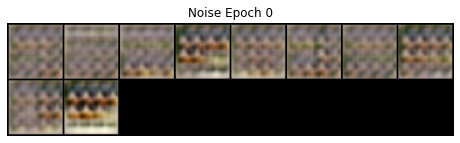

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Noise Epoch 0')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list[0:1]]

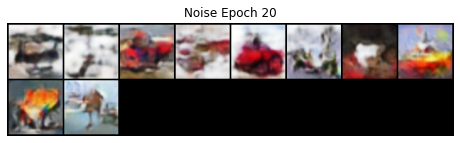

In [18]:
tr = fakeimg_list[0:50]
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Noise Epoch 20')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in tr]

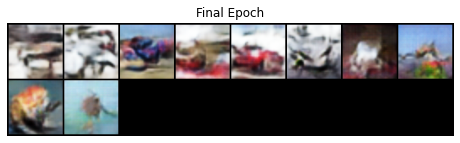

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Final Epoch')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list]

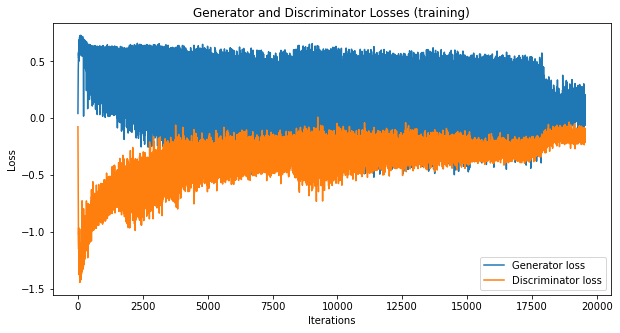

In [20]:
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Losses (training)')
plt.plot(loss_ge,label = "Generator loss")
plt.plot(loss_de,label = "Discriminator loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torchvision.utils as utils

In [22]:
real_batch = next(iter(train_loader))

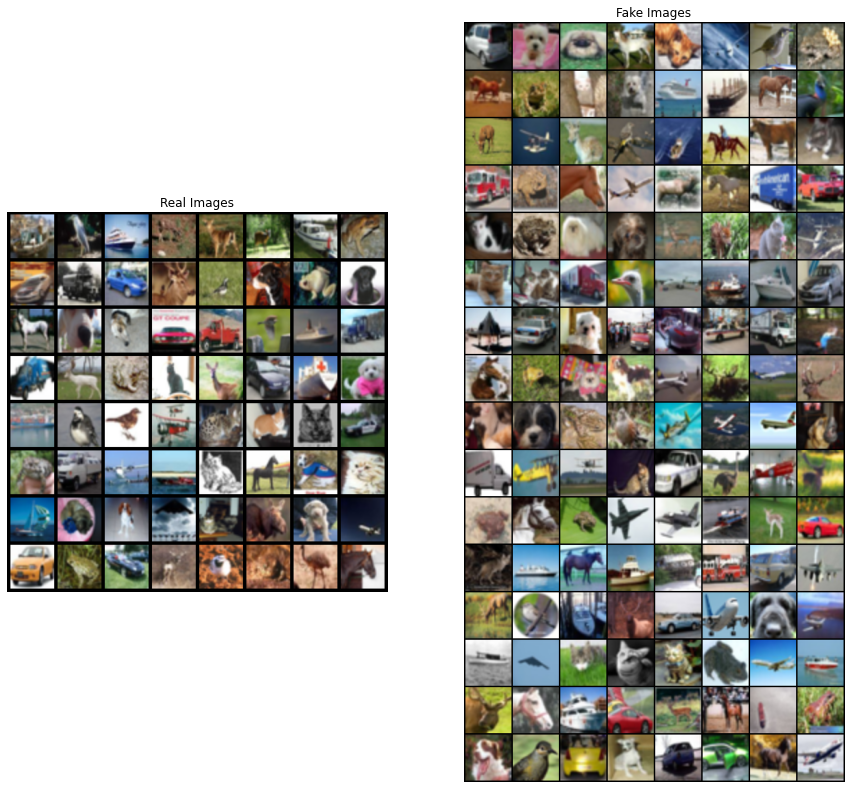

In [23]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('compare.png')
plt.show()